In [ ]:
!pip install websocket-client requests pandas

In [ ]:
import json
import requests
import pandas as pd
import websocket
import threading
from datetime import datetime

In [ ]:
# Function to get historical klines from Binance REST API
def get_historical_klines(symbol="BTCUSDT", interval="1m", start=None, end=None, limit=1000):
    """
    Fetch historical candlestick (OHLCV) data from Binance.
    
    Parameters:
    - symbol: Trading pair (e.g., BTCUSDT)
    - interval: Candle interval ('1m', '5m', '1h', '1d', etc.)
    - start, end: timestamps in milliseconds (optional)
    - limit: max rows (default 1000)
    """
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    if start: params["startTime"] = start
    if end: params["endTime"] = end
    
    resp = requests.get(url, params=params)
    data = resp.json()
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    # Convert timestamps
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    
    # Convert numeric columns
    num_cols = ["open","high","low","close","volume"]
    df[num_cols] = df[num_cols].astype(float)
    
    return df

# Example: Last 500 1-minute candles
klines_df = get_historical_klines(symbol="BTCUSDT", interval="1m", limit=500)
klines_df.head(6)



,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_base,taker_buy_quote,ignore
0,2025-09-28 21:32:00,110720.90,110720.91,110699.65,110699.65,5.14283,2025-09-28 21:32:59.999,569337.91700010,939,1.66238000,184025.73477680,0
1,2025-09-28 21:33:00,110699.65,110699.66,110675.71,110675.71,3.34099,2025-09-28 21:33:59.999,369811.65574350,886,0.41578000,46018.83361890,0
2,2025-09-28 21:34:00,110675.72,110675.72,110675.71,110675.71,7.37778,2025-09-28 21:34:59.999,816541.08835390,231,4.86301000,538217.13311720,0
3,2025-09-28 21:35:00,110675.71,110675.72,110656.73,110661.09,5.30403,2025-09-28 21:35:59.999,586976.83160130,879,1.51152000,167260.79652670,0
4,2025-09-28 21:36:00,110661.09,110666.56,110661.08,110666.55,6.25313,2025-09-28 21:36:59.999,692001.03452730,262,5.92669000,655875.27070760,0
5,2025-09-28 21:37:00,110666.55,110666.56,110661.09,110661.09,2.22813,2025-09-28 21:37:59.999,246579.01350650,230,0.15121000,16733.68709800,0


In [ ]:
klines_df.shape

(500, 12)

In [ ]:
klines_df.dtypes

open_time             datetime64[ns]
open                         float64
high                         float64
low                          float64
close                        float64
volume                       float64
close_time            datetime64[ns]
quote_asset_volume            object
trades                         int64
taker_buy_base                object
taker_buy_quote               object
ignore                        object
dtype: object

In [ ]:
klines_df.describe()

,open_time,open,high,low,close,volume,close_time,trades
count,500,500.00000,500.000000,500.000000,500.000000,500.000000,500,500.000000
mean,2025-09-29 01:41:30,111813.98960,111836.222100,111795.618780,111815.970140,9.878394,2025-09-29 01:42:29.999000064,1843.312000
min,2025-09-28 21:32:00,110643.45000,110649.980000,110640.810000,110643.460000,0.061430,2025-09-28 21:32:59.999000,15.000000
25%,2025-09-28 23:36:45,111699.99000,111716.465000,111681.062500,111700.870000,3.161185,2025-09-28 23:37:44.999000064,763.500000
50%,2025-09-29 01:41:30,111826.31000,111841.705000,111812.135000,111826.315000,6.388780,2025-09-29 01:42:29.999000064,1505.000000
75%,2025-09-29 03:46:15,112067.62250,112098.397500,112046.785000,112067.612500,11.651262,2025-09-29 03:47:14.999000064,2396.500000
max,2025-09-29 05:51:00,112315.26000,112350.000000,112313.970000,112315.260000,145.733670,2025-09-29 05:51:59.999000,17446.000000
std,NaN,357.64971,358.865321,353.225378,354.309979,13.233563,NaN,1689.784166


In [ ]:
klines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   open_time           500 non-null    datetime64[ns]
 1   open                500 non-null    float64       
 2   high                500 non-null    float64       
 3   low                 500 non-null    float64       
 4   close               500 non-null    float64       
 5   volume              500 non-null    float64       
 6   close_time          500 non-null    datetime64[ns]
 7   quote_asset_volume  500 non-null    object        
 8   trades              500 non-null    int64         
 9   taker_buy_base      500 non-null    object        
 10  taker_buy_quote     500 non-null    object        
 11  ignore              500 non-null    object        
dtypes: datetime64[ns](2), float64(5), int64(1), object(4)
memory usage: 47.0+ KB


In [ ]:
import mplfinance as mpf

In [ ]:
klines_df.set_index('close_time').tail(100)

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_base,taker_buy_quote,ignore
close_time,,,,,,,,,,,
2025-09-29 04:12:59.999,2025-09-29 04:12:00,111829.93,111829.93,111800.00,111827.91,7.98227,892499.31510920,2219,1.79580000,200780.58646990,0
2025-09-29 04:13:59.999,2025-09-29 04:13:00,111827.92,111850.00,111811.01,111811.01,5.20036,581591.14527560,2121,1.42351000,159201.59546340,0
2025-09-29 04:14:59.999,2025-09-29 04:14:00,111811.01,111819.23,111806.01,111806.01,2.92804,327393.18447030,1043,0.39516000,44184.19320990,0
2025-09-29 04:15:59.999,2025-09-29 04:15:00,111806.01,111806.02,111771.00,111771.01,9.63391,1076985.70046740,2095,0.23879000,26692.95150870,0
2025-09-29 04:16:59.999,2025-09-29 04:16:00,111771.00,111792.52,111755.42,111783.77,9.15460,1023194.22276080,1747,3.24663000,362861.07092590,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-29 05:47:59.999,2025-09-29 05:47:00,111704.38,111704.38,111704.37,111704.38,1.02237,114203.20386530,92,0.71084000,79403.94147920,0
2025-09-29 05:48:59.999,2025-09-29 05:48:00,111704.38,111711.00,111704.37,111711.00,4.45262,497399.41075630,452,4.22961000,472487.74957980,0
2025-09-29 05:49:59.999,2025-09-29 05:49:00,111711.00,111711.00,111710.99,111711.00,1.14918,128376.04154850,248,0.60603000,67700.21733000,0


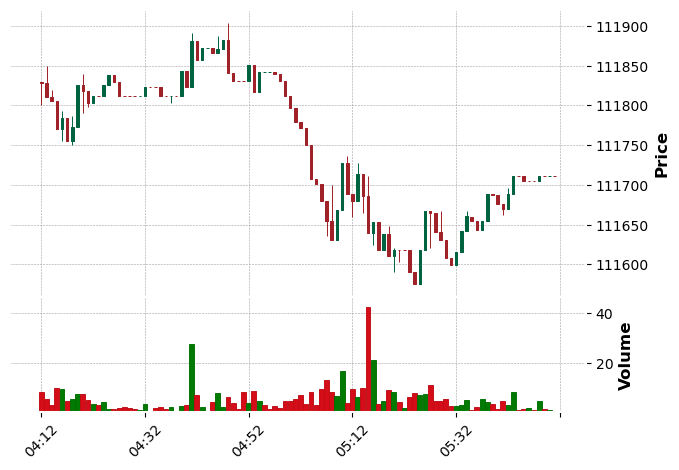

In [ ]:
mpf.plot(klines_df.set_index('close_time').tail(100),
        type='candle', style='charles',
        volume=True,)

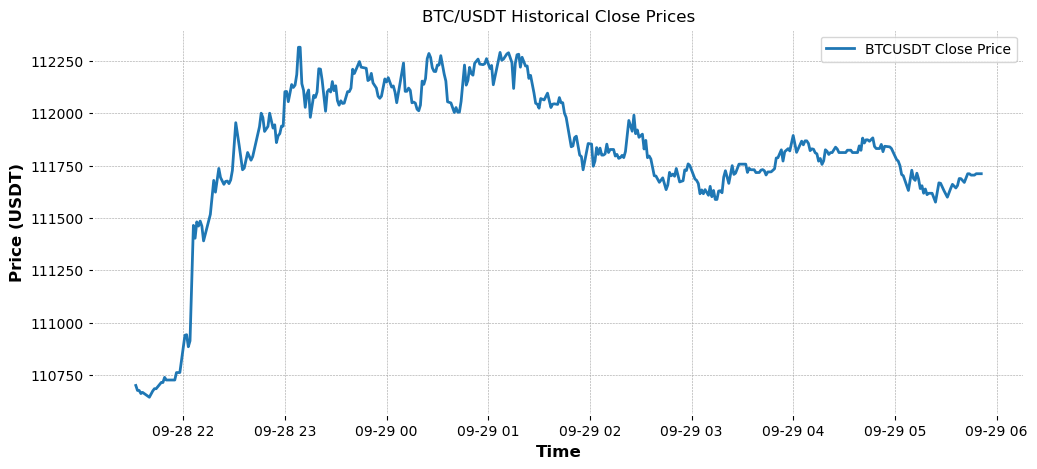

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(klines_df["open_time"], klines_df["close"], label="BTCUSDT Close Price")
plt.title("BTC/USDT Historical Close Prices")
plt.xlabel("Time")
plt.ylabel("Price (USDT)")
plt.legend()
plt.show()


In [ ]:
# Live BTC/USDT aggTrade stream
stream_url = "wss://stream.binance.com:9443/ws/btcusdt@aggTrade"

def on_message(ws, message):
    data = json.loads(message)
    price = float(data['p'])   # trade price
    qty = float(data['q'])     # trade quantity
    trade_time = datetime.fromtimestamp(data['T']/1000)
    print(f"[{trade_time}] Price: {price}, Qty: {qty}")

def on_error(ws, error):
    print("Error:", error)

def on_close(ws, close_status_code, close_msg):
    print("WebSocket closed")

def run_ws():
    ws = websocket.WebSocketApp(stream_url,
                                on_message=on_message,
                                on_error=on_error,
                                on_close=on_close)
    ws.run_forever()

# Run WebSocket in background thread
ws_thread = threading.Thread(target=run_ws)
ws_thread.start()


[2025-09-29 11:21:11.943000] Price: 111711.03, Qty: 0.0021
[2025-09-29 11:21:12.187000] Price: 111711.04, Qty: 6e-05
[2025-09-29 11:21:12.672000] Price: 111711.04, Qty: 8e-05
[2025-09-29 11:21:14.221000] Price: 111711.04, Qty: 0.0001
[2025-09-29 11:21:14.636000] Price: 111711.03, Qty: 0.00016
[2025-09-29 11:21:14.855000] Price: 111711.04, Qty: 0.0005
[2025-09-29 11:21:15.506000] Price: 111711.04, Qty: 0.0001
[2025-09-29 11:21:15.569000] Price: 111711.04, Qty: 0.00044
[2025-09-29 11:21:15.584000] Price: 111711.04, Qty: 7e-05
[2025-09-29 11:21:16.091000] Price: 111711.04, Qty: 0.00022
[2025-09-29 11:21:16.808000] Price: 111711.04, Qty: 0.0009
[2025-09-29 11:21:17.216000] Price: 111711.04, Qty: 0.00053
[2025-09-29 11:21:17.352000] Price: 111711.03, Qty: 0.00096
[2025-09-29 11:21:17.352000] Price: 111711.04, Qty: 0.00096
[2025-09-29 11:21:17.619000] Price: 111711.04, Qty: 0.00268
[2025-09-29 11:21:17.743000] Price: 111711.04, Qty: 0.00141
[2025-09-29 11:21:18.040000] Price: 111711.04, Qty:

In [ ]:
klines_df = get_historical_klines(symbol="BTCUSDT", interval="1m", limit=500)
klines_df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_base,taker_buy_quote,ignore
0,2025-09-28 21:32:00,110720.90,110720.91,110699.65,110699.65,5.14283,2025-09-28 21:32:59.999,569337.91700010,939,1.66238000,184025.73477680,0
1,2025-09-28 21:33:00,110699.65,110699.66,110675.71,110675.71,3.34099,2025-09-28 21:33:59.999,369811.65574350,886,0.41578000,46018.83361890,0
2,2025-09-28 21:34:00,110675.72,110675.72,110675.71,110675.71,7.37778,2025-09-28 21:34:59.999,816541.08835390,231,4.86301000,538217.13311720,0
3,2025-09-28 21:35:00,110675.71,110675.72,110656.73,110661.09,5.30403,2025-09-28 21:35:59.999,586976.83160130,879,1.51152000,167260.79652670,0
4,2025-09-28 21:36:00,110661.09,110666.56,110661.08,110666.55,6.25313,2025-09-28 21:36:59.999,692001.03452730,262,5.92669000,655875.27070760,0


In [ ]:
klines_df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_base,taker_buy_quote,ignore
0,2025-09-28 21:32:00,110720.90,110720.91,110699.65,110699.65,5.14283,2025-09-28 21:32:59.999,569337.91700010,939,1.66238000,184025.73477680,0
1,2025-09-28 21:33:00,110699.65,110699.66,110675.71,110675.71,3.34099,2025-09-28 21:33:59.999,369811.65574350,886,0.41578000,46018.83361890,0
2,2025-09-28 21:34:00,110675.72,110675.72,110675.71,110675.71,7.37778,2025-09-28 21:34:59.999,816541.08835390,231,4.86301000,538217.13311720,0
3,2025-09-28 21:35:00,110675.71,110675.72,110656.73,110661.09,5.30403,2025-09-28 21:35:59.999,586976.83160130,879,1.51152000,167260.79652670,0
4,2025-09-28 21:36:00,110661.09,110666.56,110661.08,110666.55,6.25313,2025-09-28 21:36:59.999,692001.03452730,262,5.92669000,655875.27070760,0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2025-09-29 05:47:00,111704.38,111704.38,111704.37,111704.38,1.02237,2025-09-29 05:47:59.999,114203.20386530,92,0.71084000,79403.94147920,0
496,2025-09-29 05:48:00,111704.38,111711.00,111704.37,111711.00,4.45262,2025-09-29 05:48:59.999,497399.41075630,452,4.22961000,472487.74957980,0
497,2025-09-29 05:49:00,111711.00,111711.00,111710.99,111711.00,1.14918,2025-09-29 05:49:59.999,128376.04154850,248,0.60603000,67700.21733000,0
498,2025-09-29 05:50:00,111711.00,111711.04,111710.99,111711.04,0.66798,2025-09-29 05:50:59.999,74620.72503120,247,0.51603000,57646.23764310,0


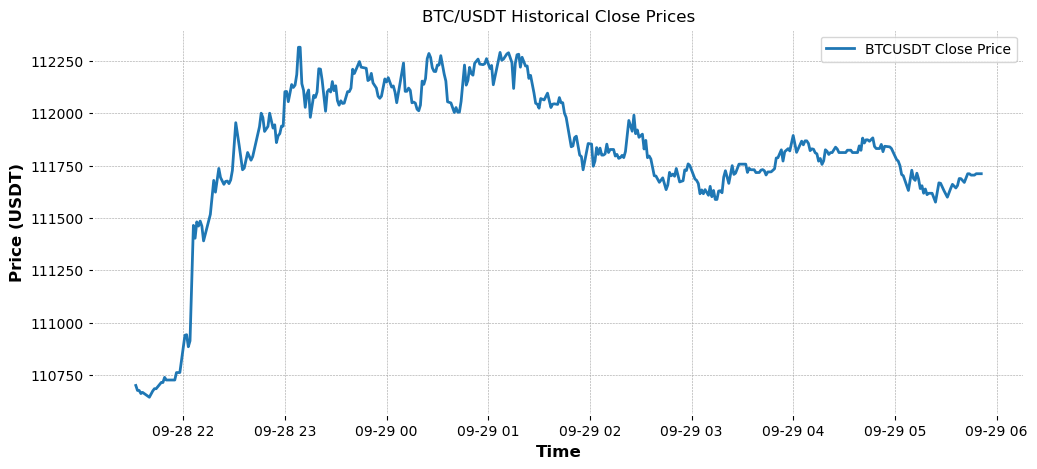

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(klines_df["open_time"], klines_df["close"], label="BTCUSDT Close Price")
plt.title("BTC/USDT Historical Close Prices")
plt.xlabel("Time")
plt.ylabel("Price (USDT)")
plt.legend()
plt.show()

In [ ]:
ws_thread = threading.Thread(target=run_ws)
ws_thread.start()

[2025-09-29 11:21:11.943000] Price: 111711.03, Qty: 0.0021
[2025-09-29 11:21:12.187000] Price: 111711.04, Qty: 6e-05
[2025-09-29 11:21:12.672000] Price: 111711.04, Qty: 8e-05
[2025-09-29 11:21:14.221000] Price: 111711.04, Qty: 0.0001
[2025-09-29 11:21:14.636000] Price: 111711.03, Qty: 0.00016
[2025-09-29 11:21:14.855000] Price: 111711.04, Qty: 0.0005
[2025-09-29 11:21:15.506000] Price: 111711.04, Qty: 0.0001
[2025-09-29 11:21:15.569000] Price: 111711.04, Qty: 0.00044
[2025-09-29 11:21:15.584000] Price: 111711.04, Qty: 7e-05
[2025-09-29 11:21:16.091000] Price: 111711.04, Qty: 0.00022
[2025-09-29 11:21:16.808000] Price: 111711.04, Qty: 0.0009
[2025-09-29 11:21:17.216000] Price: 111711.04, Qty: 0.00053
[2025-09-29 11:21:17.352000] Price: 111711.03, Qty: 0.00096
[2025-09-29 11:21:17.352000] Price: 111711.04, Qty: 0.00096
[2025-09-29 11:21:17.619000] Price: 111711.04, Qty: 0.00268
[2025-09-29 11:21:17.743000] Price: 111711.04, Qty: 0.00141
[2025-09-29 11:21:18.040000] Price: 111711.04, Qty:

In [ ]:
import json
import websocket

In [ ]:
SOCKET = "wss://stream.binance.com:9443/ws/btcusdt@aggTrade"

In [ ]:
import json
import pandas as pd
from datetime import datetime
import websocket
import os

# 🔹 CSV file path
CSV_FILE = "btc_trades.csv"

# 🔹 Create CSV with headers if it doesn’t exist
if not os.path.exists(CSV_FILE):
    columns = ["trade_time", "price", "quantity", "is_buyer_maker"]
    pd.DataFrame(columns=columns).to_csv(CSV_FILE, index=False)

# 🔹 Callback when Binance sends a message
def on_message(ws, message):
    data = json.loads(message)

    # Extract useful trade info
    trade = {
        "trade_time": datetime.fromtimestamp(data['T'] / 1000),  # timestamp (ms → datetime)
        "price": float(data['p']),
        "quantity": float(data['q']),
        "is_buyer_maker": data['m']  # True if seller is the market maker
    }

    # Save row into CSV (append mode, no header)
    df = pd.DataFrame([trade])
    df.to_csv(CSV_FILE, mode='a', header=False, index=False)

    # Optional: print live
    print(trade)

def on_error(ws, error):
    print("Error:", error)

def on_close(ws, close_status_code, close_msg):
    print("### WebSocket closed ###")

def on_open(ws):
    print("✅ Connected to Binance WebSocket!")

# 🔹 Connect to Binance WebSocket
SOCKET = "wss://stream.binance.com:9443/ws/btcusdt@aggTrade"

ws = websocket.WebSocketApp(
    SOCKET,
    on_message=on_message,
    on_error=on_error,
    on_close=on_close
)

ws.on_open = on_open
ws.run_forever()


✅ Connected to Binance WebSocket!
{'trade_time': datetime.datetime(2025, 9, 29, 11, 21, 12, 187000), 'price': 111711.04, 'quantity': 6e-05, 'is_buyer_maker': False}
{'trade_time': datetime.datetime(2025, 9, 29, 11, 21, 12, 672000), 'price': 111711.04, 'quantity': 8e-05, 'is_buyer_maker': False}
{'trade_time': datetime.datetime(2025, 9, 29, 11, 21, 14, 221000), 'price': 111711.04, 'quantity': 0.0001, 'is_buyer_maker': False}
{'trade_time': datetime.datetime(2025, 9, 29, 11, 21, 14, 636000), 'price': 111711.03, 'quantity': 0.00016, 'is_buyer_maker': True}
{'trade_time': datetime.datetime(2025, 9, 29, 11, 21, 14, 855000), 'price': 111711.04, 'quantity': 0.0005, 'is_buyer_maker': False}
{'trade_time': datetime.datetime(2025, 9, 29, 11, 21, 15, 506000), 'price': 111711.04, 'quantity': 0.0001, 'is_buyer_maker': False}
{'trade_time': datetime.datetime(2025, 9, 29, 11, 21, 15, 569000), 'price': 111711.04, 'quantity': 0.00044, 'is_buyer_maker': False}
{'trade_time': datetime.datetime(2025, 9, 2

True